# Stratification

Links:
    - https://en.wikipedia.org/wiki/Stratified_sampling
    - https://en.wikipedia.org/wiki/Sample_size_determination
    - https://www.youtube.com/watch?v=Nnui2Xa0qRU&index=3&list=PLlb7e2G7aSpRG_Ve6kuxc9Biuwyf42kJx

# Libs

In [0]:
import matplotlib.mlab as mlab
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Population

Зададим доли страт нормальных распределений в генеральной совокупности

In [0]:
weight_0 = 0.2
weight_1 = 0.5
weight_2 = 0.3

weights = [weight_0, weight_1, weight_2]

# Simple random

Функция простого случайного выбора. Возвращает среднее и дисерсию выборки размера size. Согласно весам распределений weights случайно выбирается одно из трёх распределений. Из выбранного распределения (согласно параметрам распределения из датафрейма distributions) выбирается случайное значение, которое и записывается в выборку.

In [0]:
def simple_random_sampling(size, weights, distributions):

    sample = []
    choices = []

    #Выбираем распределения случайным образом согласно вероятностям из листа weights
    choices.extend(np.random.choice(range(len(weights)), size=size, p=weights))

    for i in range(len(weights)):
        #Добавляем в лист случайные значения из i-ого распределения согласно его доле
        sample.extend(
            np.random.normal(loc=distributions.at[i, 'mean'],
                             scale=math.sqrt(distributions.at[i, 'variance']),
                             size=choices.count(i)))

    return np.asarray(sample).mean(), np.asarray(sample).var()

# Proportional

Функция пропорционального разбиения на подсэпмлы. Возвращает среднее и дисерсию выборки размера size. Количество случайных значений из k-ого нормального распределения вычисляется по формуле:  
$$n_l = n\frac{N_l}{N}, \mathrm{Var}[\bar{X}_{SP}]=\frac{1}{n}\sum_{k=1}^{L}W_k\sigma_k^2$$

In [0]:
def proportional_sampling(size, weights, distributions):

    means = []
    variances = []

    for i in range(len(weights)):
        sample = []
        #Добавляем в лист случайные значения из i-ого распределения согласно его доле
        sample.extend(
            np.random.normal(loc=distributions.at[i, 'mean'],
                             scale=math.sqrt(distributions.at[i, 'variance']),
                             size=int(size * weights[i])))
        means.append(np.asarray(sample).mean())
        variances.append(np.asarray(sample).var())

    #Преобразуем переменные в векторный вид для упрощения записи циклических операций
    weights = np.array(weights)
    means = np.array(means)

    expected_mean = np.sum(weights * means)
    expected_variance = np.sum(weights * variances) + np.sum(
        weights * (expected_mean - means)**2)

    return expected_mean, expected_variance

# Optimal

Функция оптимальноого разбиения на подсэпмлы. Возвращает среднее и дисерсию выборки размера size. Количество случайных значений из k-ого нормального распределения вычисляется по формуле: 
$$\mathrm{Var}[\bar{X}_S] \rightarrow \min$$
$$n_l = n\frac{W_l\sigma_l}{\sum_{k=1}^{L}W_k\sigma_k}, \mathrm{Var}[\bar{X}_{SO}]=\frac{1}{n}\left(\sum_{k=1}^{L}W_k\sigma_k\right)^2$$

In [0]:
def optimal_sampling(size, weights, distributions):

    #вычисление знаменателя приведённой выше формулы
    denominator = 0
    for i in range(len(weights)):
        denominator += weights[i] * math.sqrt(distributions.at[i, 'variance'])

    volume_of_stratum = []
    #вычисленные объёмы первых двух страт округляются в меньшую сторону,
    #а объём последней страты вычисляется как разность между объёмом выборки и суммой объёмов первых двух страт
    for i in range(len(weights) - 1):
        volume_of_stratum.append(
            math.floor(size * weights[i] *
                       math.sqrt(distributions.at[i, 'variance']) /
                       denominator))
    volume_of_stratum.append(size - volume_of_stratum[1] -
                             volume_of_stratum[0])

    means = []
    variances = []

    for i in range(len(weights)):
        sample = []
        #Добавляем в лист случайные значения из i-ого распределения согласно его доле
        sample.extend(
            np.random.normal(loc=distributions.at[i, 'mean'],
                             scale=math.sqrt(distributions.at[i, 'variance']),
                             size=volume_of_stratum[i]))
        means.append(np.asarray(sample).mean())
        variances.append(np.asarray(sample).var())

    #Преобразуем переменные в векторный вид для упрощения записи циклических операций
    weights = np.array(weights)
    means = np.array(means)

    expected_mean = np.sum(weights * means)
    expected_variance = np.sum(weights * variances) + np.sum(
        weights * (expected_mean - means)**2)

    return expected_mean, expected_variance

# Support functions

Функция моделирования нужного количества (reiterations) выборок заданного объёма size. Разбиение на подсэмплы происходит согласно функции function. Функция моделирования возвращает DataFrame, где каждой строчке соответствует выборка. Для каждой выборки указан метод сэмплирования, среднее выборки и дисперсия выборки

In [0]:
def modelling(weights, distributions, function, size, reiterations):

    df = pd.DataFrame(columns=['method', 'mean', 'variance'])

    for i in range(reiterations):
        sample_mean, sample_variance = function(size, weights, distributions)
        func_name = function.__name__
        df = df.append(pd.DataFrame(
            data=[[func_name, sample_mean, sample_variance]],
            columns=['method', 'mean', 'variance']),
                       ignore_index=True)
    return df

Функция моделирования нужного количества (reiterations) выборок заданного объёма size. Моделирование происходит для каждого способа разбиения на посэмплы. Все выборки записываются в один DataFrame, который и возвращается.

In [0]:
def modelling_all_samplings(weights, distributions, size, reiterations=1000):

    model = pd.DataFrame(columns=['method', 'mean', 'variance'])

    functions = [simple_random_sampling, proportional_sampling, optimal_sampling]

    for i in range(len(functions)):
        df_size = modelling(weights, distributions, functions[i], size,
                            reiterations)
        model = model.append(df_size, ignore_index=True)

    return model

Функция для вывода графиков boxplot для средних значений и для дисперсий. Производится разделение по методам для более удобного анализа

In [0]:
def showing_model_properties(model):
    g = sns.FacetGrid(data=model, col='method', size=3)
    g.map(sns.boxplot, 'mean', order=(0, 1), orient='v')
    plt.show()

    g = sns.FacetGrid(data=model, col='method', size=3)
    g.map(sns.boxplot, 'variance', order=(0, 1), orient='v')
    plt.show()

In [0]:
def show_mixture_estimation(weights, data):
    expected_mean = weights[0] * data.get('mean')[0] + weights[1] * data.get(
        'mean')[1] + weights[2] * data.get('mean')[2]
    expected_variance = 0
    for i in range(len(weights)):
        expected_variance += weights[i] * data.get('variance')[i]
        expected_variance += weights[i] * math.pow(
            (expected_mean - data.get('mean')[i]), 2)

    print('expected_mean=', expected_mean, 'expected_variance',
          expected_variance)

# Modelling 

## Зададим параметры нормально распределённых случайных величин согласно случаю А: все страты имеют одинаковые мат. ожидания и дисперсии

In [0]:
data = {'mean': [0, 0, 0], 'variance': [1, 1, 1]}
distributions = pd.DataFrame(data=data)

#### Смоделируем 1000 выборок, объёмом 40 значений каждая. И выведем графики с помощью функции showing_model_properties

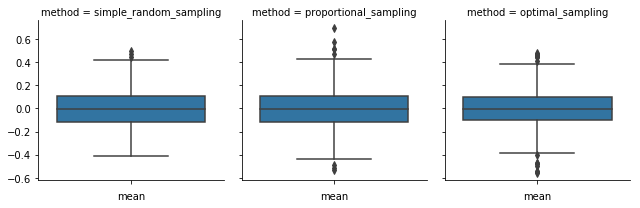

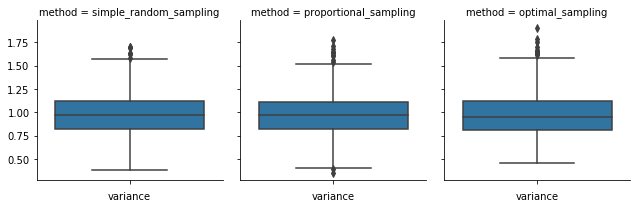

In [0]:
model_40 = modelling_all_samplings(weights, distributions, 40, 1000)
showing_model_properties(model_40)

#### Аналогично смоделируем 1000 выборок, но уже объёмом 500 значений каждая

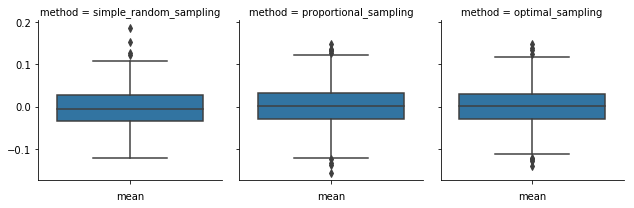

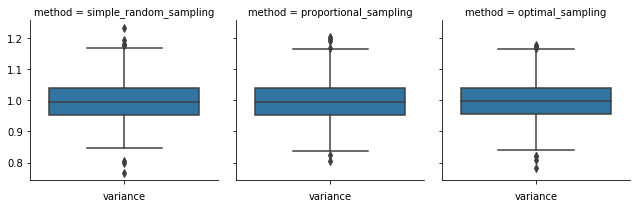

In [0]:
model_500 = modelling_all_samplings(weights, distributions, 500, 1000)
showing_model_properties(model_500)

In [0]:
show_mixture_estimation(weights, data)

expected_mean= 0.0 expected_variance 1.0


Мат. ожидание и дисперсия генеральной совокупности равны 0 и 1 соответственно.

Так как параметры всех трёх с.в. одинаковы, то разницы между первым и вторым способом сэмплирования нет: брать значения случайно из трёх одинаковых распределений или же пропорционально из трёх одинаковых распределений - одно и то же.
Также второй способ идентичен третьему, так как дисперсии у трёх с.в. равны, а значит, доли этих с.в. не изменятся в оптимальном сэмплировании.

Получается, что в случае, когда нормально распределённые случайные величины, составляющие генеральную совокупность, имеют одинаковые мат. ожидания и дисперсии, данные способы сэмплирования не отличаются друг от друга.

Какими свойствами обладают оценки на основе полученных выборок:

1. Все три способа дают несмещённую оценку, так как мат ожидание среднего и мат ожидание дисперсии совпадают с параметрами г.с.
2. Все три способа дают состоятельную оценку. В этом можно убедиться, обратив внимание на графики второй модели, где размеры выборки увеличены до 500 вместо 40. С увеличением объёма выборки интерквартильный размах сузился, то есть разброс оценки уменьшается.
3. Все три способа эффективны. Дисперсии всех оценок одинаковы, поэтому каждую дисперсию можно считать минимальной

## Зададим параметры нормально распределённых случайных величин согласно случаю Б: страты имеют разные мат.ожидания, но одинаковые дисперсии

In [0]:
data = {'mean': [0, 5, 10], 'variance': [1, 1, 1]}
distributions = pd.DataFrame(data=data)

#### Смоделируем 1000 выборок, объёмом 40 значений каждая. И выведем графики с помощью функции showing_model_properties

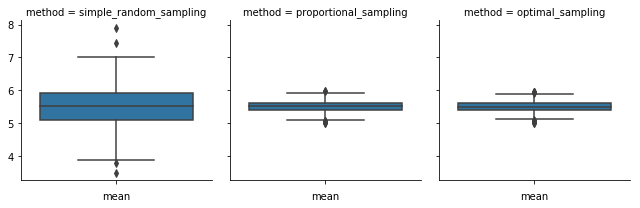

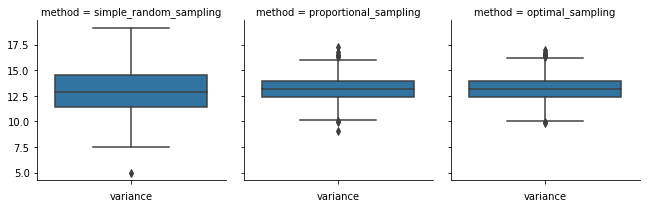

In [0]:
model_40 = modelling_all_samplings(weights, distributions, 40, 1000)
showing_model_properties(model_40)

#### Аналогично смоделируем 1000 выборок, но уже объёмом 500 значений каждая

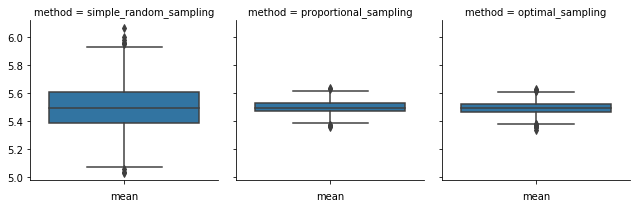

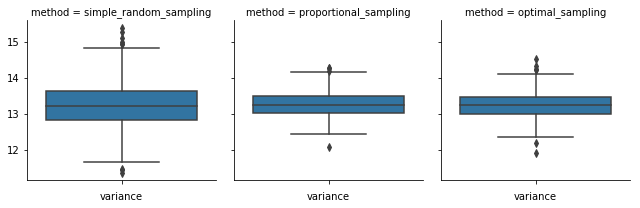

In [0]:
model_500 = modelling_all_samplings(weights, distributions, 500, 1000)
showing_model_properties(model_500)

In [0]:
show_mixture_estimation(weights, data)

expected_mean= 5.5 expected_variance 13.25


Мат. ожидание и дисперсия генеральной совокупности равны 5.5 и 13.25 соответственно.

Второй способ так же идентичен третьему, так как дисперсии у трёх с.в. равны, а значит, доли этих с.в. не изменятся в оптимальном сэмплировании.
Но так как средние значения всех трёх с.в. разные, мы видим заметную разницу в разбросах значений между первым способом и вторыми двумя. Разброс у первого способа больше, так как иногда выборки набираются не точно согласно долям страт и получаются более изменчивыми.

Получается, что в случае, когда нормально распределённые случайные величины, составляющие генеральную совокупность, имеют разные мат. ожидания и одинаковые дисперсии, пропорциональный и оптимальный способы разбиения на подсэмплы не отличаются друг от друга и дают меньший разброс, нежели простой случайный выбор.

Какими свойствами обладают оценки на основе полученных выборок:

1. Все три способа дают несмещённую оценку, так как мат ожидание среднего и мат ожидание дисперсии совпадают с параметрами г.с.
2. Все три способа дают состоятельную оценку. В этом можно убедиться, обратив внимание на графики второй модели, где размеры выборки увеличены до 500 вместо 40. С увеличением объёма выборки интерквартильный размах сузился, то есть разброс оценки уменьшается.
3. Пропорциональный и оптимальный способ одинаково эффективнее случайного, так как дают меньший разброс оценок мат. ожидания и дисперсии.

## Зададим параметры нормально распределённых случайных величин согласно случаю В: страты имеют разные и мат. ожидания и дисперсии.

In [0]:
data = {'mean': [1, 5, 10], 'variance': [1000, 4, 1]}
distributions = pd.DataFrame(data=data)

#### Смоделируем 1000 выборок, объёмом 40 значений каждая. И выведем графики с помощью функции showing_model_properties

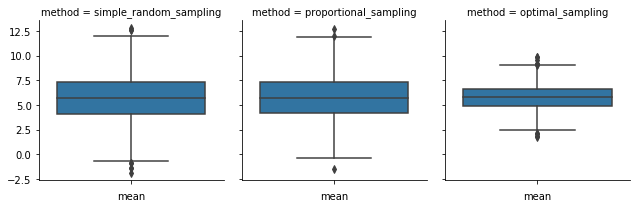

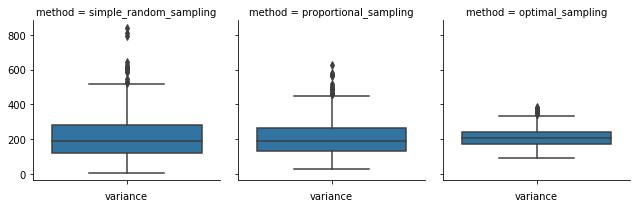

In [0]:
model_40 = modelling_all_samplings(weights, distributions, 40, 1000)
showing_model_properties(model_40)

#### Аналогично смоделируем 1000 выборок, но уже объёмом 500 значений каждая

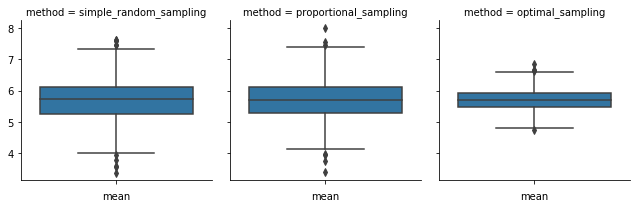

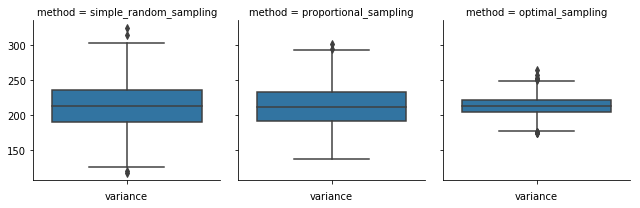

In [0]:
model_500 = modelling_all_samplings(weights, distributions, 500, 1000)
showing_model_properties(model_500)

In [0]:
show_mixture_estimation(weights, data)

expected_mean= 5.7 expected_variance 212.51000000000002


Мат. ожидание и дисперсия генеральной совокупности равны 5.7 и 212.51 соответственно.

Второй способ и третий способы перестали совпадать, так как дисперсии перестали быть равными, а значит, доли этих с.в. изменились в оптимальном сэмплировании. Разброс третьего способа стал меньше, чем у второго.
Пропорциональный способ опять же имеет чуть меньший интерквартильный размах, чем случайный способ, но при объёме выборок, равном 500, разница почти незаметна. 

Получается, что в случае, когда нормально распределённые случайные величины, составляющие генеральную совокупность, имеют разные мат. ожидания и разные дисперсии, оптимальный способ разбиения на подсэмплы имеет меньший разброс, чем пропорциональный способ. В свою очередь пропорциональный способ имеет меньший разброс, чем случайный.

Какими свойствами обладают оценки на основе полученных выборок:

1. Все три способа дают несмещённую оценку, так как мат ожидание среднего и мат ожидание дисперсии совпадают с параметрами г.с.
2. Все три способа дают состоятельную оценку. В этом можно убедиться, обратив внимание на графики второй модели, где размеры выборки увеличены до 500 вместо 40. С увеличением объёма выборки интерквартильный размах сузился, то есть разброс оценки уменьшается.
3. Оптимальный способ эффективнее двух других, так как даёт меньший разброс оценок мат. ожидания и дисперсии.